In [1]:

import argparse
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import numpy as np
import random
import wandb
import models
import yaml
from trainer import Trainer
import pprint
from torchvision import transforms
import datasets


np.random.seed(0)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

In [2]:
# Load YAML config
with open("./configs/noisycifar10/train_noisycifar10_ce_symm40.yaml", 'r') as file:
    config = yaml.safe_load(file)

# # read YAML file from string
# config = yaml.safe_load(
# """
# data:
#   dataset: noisy_cifar10
#   noise_rate: 0.4
#   noise_type: symmetric
#   random_seed: 42

# model:
#   architecture: resnet18
#   num_classes: 10

# wandb:
#   mode: disabled # "disabled" or "online"
#   entity: siit-iitp
#   project: noisy-label

# trainer:
#   optimizer: sgd
#   init_lr: 1.0e-1
#   momentum: 0.9
#   weight_decay: 1.0e-4
#   lr_scheduler: multistep
#   max_epoch: 200
#   loss_fn: cross_entropy
#   num_classes: 10
#   num_workers: 2
#   batch_size: 128
#   save_model: true
# """
# )

model = models.get_model(**config["model"]).cuda()
model = torch.jit.script(model)


WANDB_RUN_ID = "mquy2drg" # NoisyCIFAR10(symm,0.4)-CE
# WANDB_RUN_ID = "ccnf390c" # NoisyCIFAR10(symm,0.4)-MAE
# WANDB_RUN_ID = "i0qx1u8n" # NoisyCIFAR10(symm,0.4)-CE-AutoAugment


def load_checkpoint(name="model_199.pth"):
    checkpoint = wandb.restore(name, run_path=f"siit-iitp/noisy-label/{WANDB_RUN_ID}", replace=True, root='./temp')
    model.load_state_dict(torch.load(checkpoint.name, map_location="cuda"))
    print(f"Loaded checkpoint: {checkpoint.name}")

load_checkpoint(name="model_199.pth")


trainer = Trainer(
                model=model,
                config=config['trainer'],
                )

print(trainer.criterion)

Loaded checkpoint: ./temp/model_199.pth
CrossEntropyLoss()


: 

## GradCAM visualization

In [3]:
# loss magnitude-based filtering
from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F


transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train


Files already downloaded and verified


deer deer


/tmp/ipykernel_30949/2717928547.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)[None, ...].requires_grad_(True)


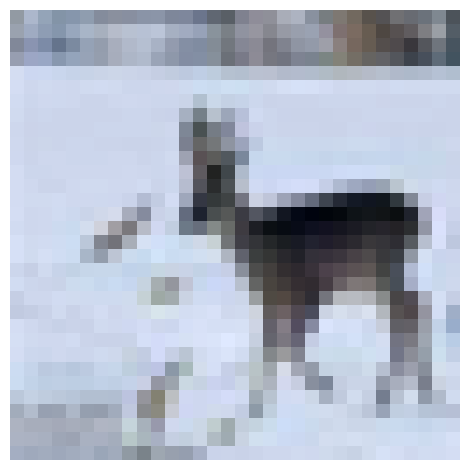

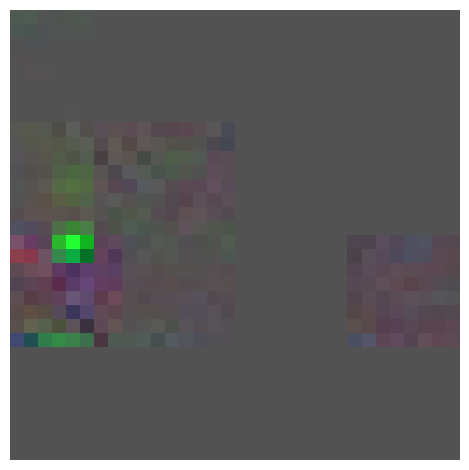

In [50]:
from captum.attr import GuidedGradCam, IntegratedGradients, Saliency, DeepLift, NoiseTunnel
from captum.attr import visualization as viz

model = model.cpu()
guided_gc = GuidedGradCam(model, model.layer4[-1])
sample = train_dataset[20]
input, target = sample['image'], sample['target']
input = torch.tensor(input)[None, ...].requires_grad_(True)
target = torch.tensor(target)

# Computes guided GradCAM attributions for class 3.
# attribution size matches input size, Nx3x32x32
attribution = guided_gc.attribute(input, target=target)

print(
    train_dataset.classes[sample['target']], 
    train_dataset.classes[sample['target_gt']], 
)
import torchshow

torchshow.show(input)
torchshow.show(attribution)


## Visualization of perturbed outputs

In [11]:
# perturbation-based filtering
# TODO: 다른 weight로도 두세번 더 돌려보기!

import torchvision
from torchvision import transforms
import torchvision.transforms.v2 as transforms_v2

from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F
import tqdm.auto as tqdm


import random
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)


auto_augment = transforms_v2.AutoAugment(AutoAugmentPolicy.CIFAR10)
random_crop = transforms.Compose([
    transforms_v2.RandomCrop(32, padding=4),
    transforms_v2.RandomHorizontalFlip(),
])
num_augment = 100

transform_train = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1)),
    # transforms.Lambda(lambda x: torch.stack([x] + [auto_augment(x) for _ in range(num_augment)], dim=0)), # (11, C, H, W)
    # transforms.Lambda(lambda x: torch.stack([x] + [random_crop(x) for _ in range(num_augment)], dim=0)), # (11, C, H, W)
    transforms.Lambda(lambda x: torch.stack([auto_augment(x) for _ in range(num_augment)] + [random_crop(x) for _ in range(num_augment)], dim=0)), # (11, C, H, W)
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010), inplace=True),
    # transforms.Lambda(lambda x: torch.stack([x] + [torch.normal(mean=x, std=0.1) for _ in range(num_augment)], dim=0)), # (11, C, H, W)
])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train

dataloader = trainer.get_dataloader(train_dataset, train=False)
dataloader.num_workers = 8

load_checkpoint(f"model_199.pth")

with torch.no_grad():
    trainer.model.eval()
    result = {
        'output': [],
        'loss': [],
        'std': [],
        'mean': [],
        'target': [],
        'target_gt': [],
    }
    for batch in tqdm.tqdm(dataloader):
        data = batch["image"].cuda() # (B, 11, 3, 32, 32)
        target = batch["target"].cuda()[:, None].repeat(1, data.size(1)) # (B, 11)
        target_gt = batch["target_gt"].cuda() # (B,)

        b = data.size(0)
        data = data
        with torch.cuda.amp.autocast():
            output = trainer.model(data.view(-1,3,32,32)) # (B*11, 10)
            loss = trainer.criterion(output, target.view(-1)).view(b, -1) # (B, 11)
        raw_loss, aug_loss = loss[:, 0], loss[:, 1:]
        std, mean = torch.std_mean(aug_loss, dim=-1)

        result['output'].append(output.view(b, -1, 10))
        result['loss'].append(raw_loss)
        result['std'].append(std)
        result['mean'].append(mean)
        result['target'].append(target[:, 0])
        result['target_gt'].append(target_gt)

    result = {k: torch.cat(v, dim=0).cpu() for k, v in result.items()}

# pprint.pprint(result)

Files already downloaded and verified
Loaded checkpoint: ./temp/model_199.pth


  0%|          | 0/391 [00:00<?, ?it/s]

In [11]:
result['output'].shape

torch.Size([50000, 100, 10])

In [12]:
import pandas as pd

df = pd.DataFrame({
    'pointpred': torch.unbind(result['output'][:,:num_augment,:]), # (50000, 10)
    'output': torch.unbind(result['output'][:,num_augment:,:]), # (50000, 10, 10)
    'is_noisy': (result['target'] != result['target_gt']).tolist(), # (50000, 11, 10)
    'target': result['target'].tolist(), # (50000,)
    'target_gt': result['target_gt'].tolist(), # (50000,)
    })

df

,pointpred,output,is_noisy,target,target_gt
0,"[[tensor(-1.7734, dtype=torch.float16), tensor...","[[tensor(-0.1132, dtype=torch.float16), tensor...",True,5,6
1,"[[tensor(3.2227, dtype=torch.float16), tensor(...","[[tensor(2.9004, dtype=torch.float16), tensor(...",False,9,9
2,"[[tensor(-2.1543, dtype=torch.float16), tensor...","[[tensor(-2.1543, dtype=torch.float16), tensor...",False,9,9
3,"[[tensor(1.9053, dtype=torch.float16), tensor(...","[[tensor(-0.0906, dtype=torch.float16), tensor...",False,4,4
4,"[[tensor(-0.8052, dtype=torch.float16), tensor...","[[tensor(-1.5039, dtype=torch.float16), tensor...",True,9,1
...,...,...,...,...,...
49995,"[[tensor(1.5342, dtype=torch.float16), tensor(...","[[tensor(0.2957, dtype=torch.float16), tensor(...",False,2,2
49996,"[[tensor(-4.2227, dtype=torch.float16), tensor...","[[tensor(-4.1211, dtype=torch.float16), tensor...",False,6,6
49997,"[[tensor(-2.3379, dtype=torch.float16), tensor...","[[tensor(-2.6035, dtype=torch.float16), tensor...",False,9,9
49998,"[[tensor(-0.4915, dtype=torch.float16), tensor...","[[tensor(-0.1610, dtype=torch.float16), tensor...",True,8,1


In [7]:
torch.set_printoptions(sci_mode=False)

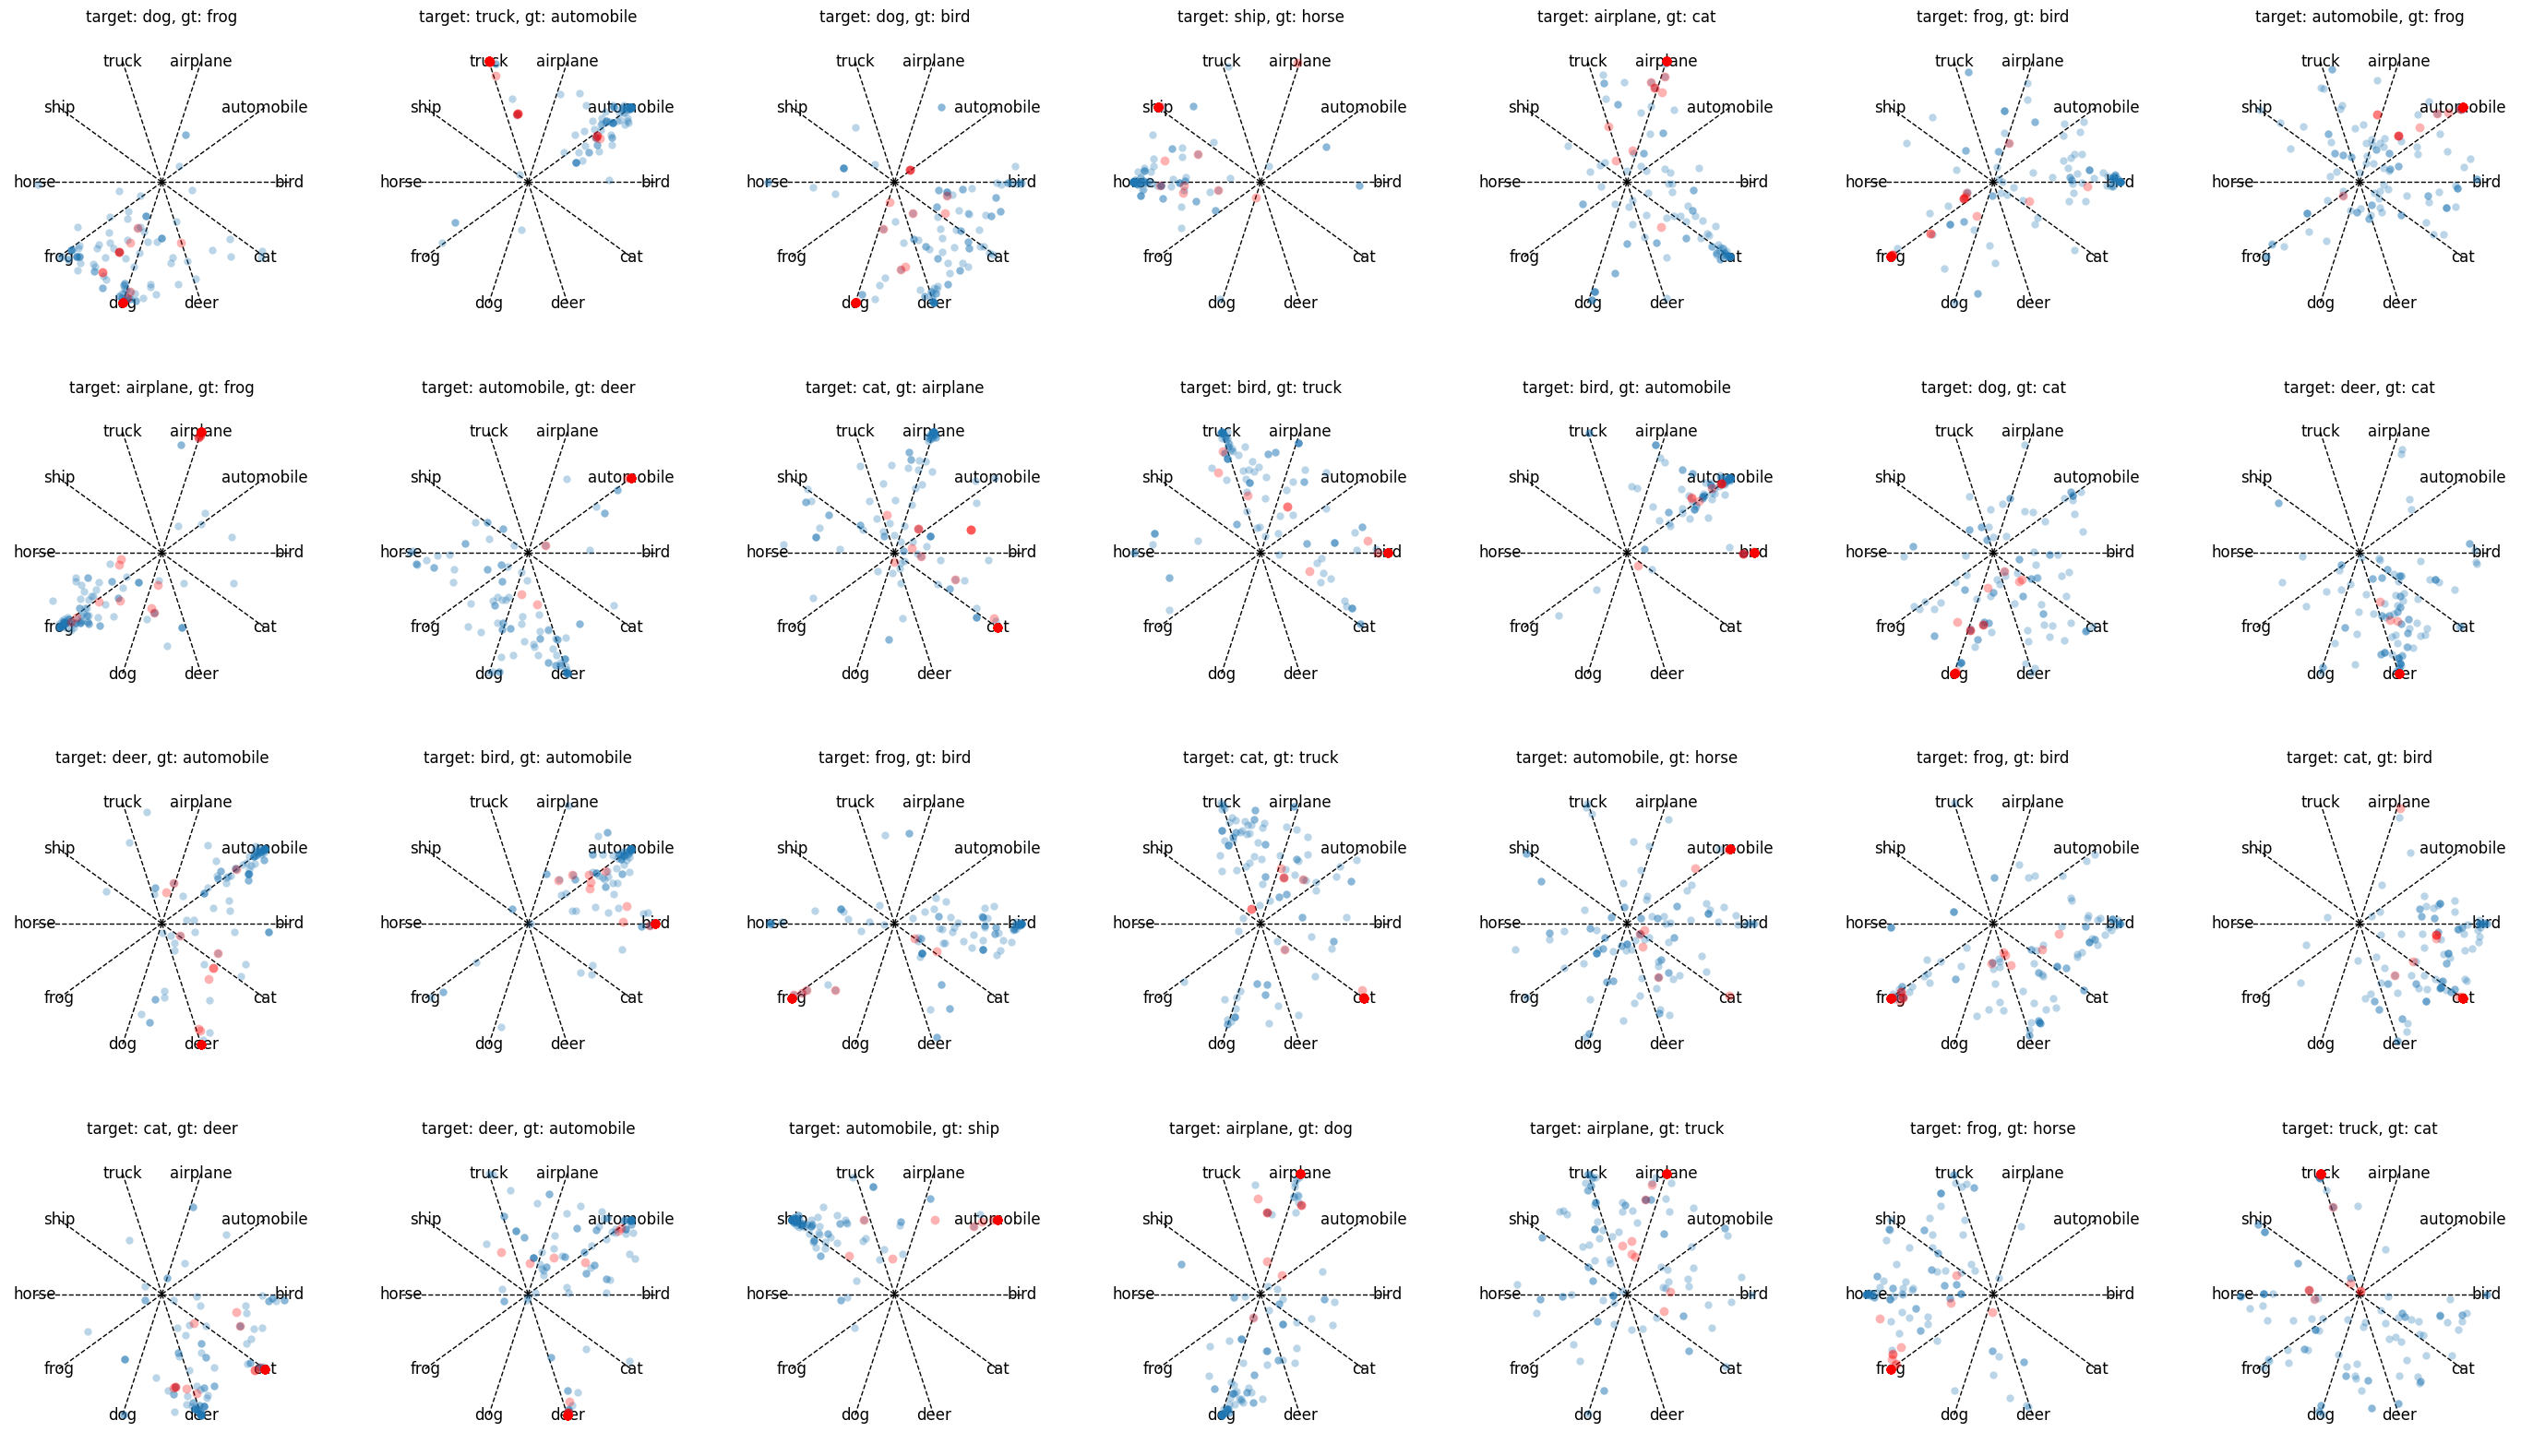

In [15]:
import numpy as np
import torch

def get_projection_matrix(k):
    theta = (2*np.pi/k) * (np.arange(k) + 0.5)
    return np.stack([np.sin(theta), np.cos(theta)], axis=0)

num_classes = 10
T = get_projection_matrix(num_classes)

df_clean = df[df['is_noisy']==False]
df_noisy = df[df['is_noisy']==True]

import numpy.random as nprn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
from scipy.special import softmax


num_class = config["model"]["num_classes"] # CIFAR-10
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize=(35,20))
for idx in range(28):
    row = df_noisy.iloc[idx]
    # row = df_clean.iloc[idx]
    x = row['output'].float().div(1).softmax(-1).numpy()
    # pointpred = row['pointpred'][None, :].softmax(-1).numpy()
    pointpred = row['pointpred'].float().div(1).softmax(-1).numpy()

    points = T @ x.T
    pointpred = T @ pointpred.T

    ax = fig.add_subplot(4,7,idx + 1)

    # Plot the octagon
    vertices = T @ np.eye(num_classes)
    vertices = np.hstack([vertices, vertices[:, 0:1]])
    for i, vertex in enumerate(vertices[:,:-1].T):
        ax.text(vertex[0], vertex[1], cifar10_classes[i], ha='center', va='center', fontsize=12)
        ax.plot([0, vertex[0]], [0, vertex[1]], 'k--', linewidth=1)

    # Plot the points
    ax.scatter(points[0], points[1], linewidth=0, alpha=0.3, zorder=10)
    ax.scatter([pointpred[0]], [pointpred[1]], color='red', alpha = 0.3, s=50, linewidth=0, zorder=12)

    # # plot image
    # plt.figimage()

    # Set the axis limits
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.set_title(f"target: {cifar10_classes[row['target']]}, gt: {cifar10_classes[row['target_gt']]}")
    ax.set_axis_off()

# Show the plot
plt.show()

[0.         0.30399999 0.49862108 0.71508169 0.87867457 0.96541643
 0.98832065 0.99731362 0.99976665 1.        ]


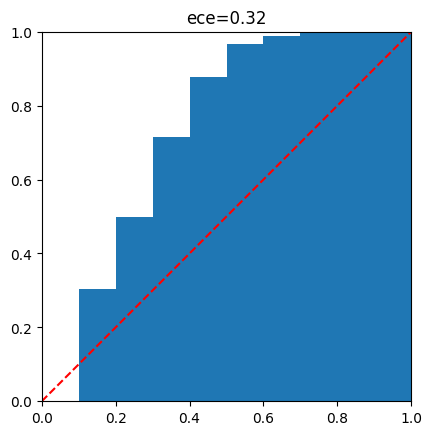

In [10]:
import matplotlib.pyplot as plt

def plot_ece(conf, correct, bin_width=0.1):

    bins = []
    bin_width = 0.1
    ece = 0.0
    for low in np.arange(0.0, 1.0, bin_width):
        mask = (confidence >= low) & (confidence < low + bin_width)
        acc = correct[mask].float().mean().item()
        bins.append(acc)
        if mask.sum() > 0:
            ece += np.abs(acc - (low + bin_width/2)) * mask.sum()
    bins = np.nan_to_num(bins)
    ece = ece / len(conf)

    fig, ax = plt.subplots()
    # ax.bar([f"{x:.2f}" for x in np.arange(0.0, 1.0, bin_width)], bins)
    ax.bar(np.arange(0.0, 1.0, bin_width), bins, align='edge', width=0.1)
    print(bins)
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')
    ax.set_title(f"{ece=:.2f}")

    # set the xlim to (0,1)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')

    plt.show()


# correct = torch.stack(tuple(df['pointpred']), dim=0).softmax(-1).argmax(-1) == torch.tensor(df['target_gt'])
# confidence = torch.stack(tuple(df['pointpred']), dim=0).softmax(-1).max(-1).values


correct = torch.stack(tuple(df['output']), dim=0).softmax(-1).mean(1).argmax(-1) == torch.tensor(df['target_gt'])
confidence = torch.stack(tuple(df['output']), dim=0).softmax(-1).mean(1).max(-1).values


plot_ece(confidence, correct)

## perturbation-based filtering

In [3]:
# perturbation-based filtering

from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F



transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train


with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    result = {
        'std': [],
        'mean': [],
        'is_noisy': [],
    }
    for batch in dataloader:
        data, target = batch["image"].cuda(), batch["target"].cuda()
        target_gt = batch["target_gt"].cuda()
        losses = []
        for _ in range(10):
            # data_ = torch.normal(transform_normalize(data), 0.1)
            data_ = transform_tta(data)
            output = trainer.model(data_)
            loss = trainer.criterion(output, target)
            losses.append(loss)
        std, mean = torch.std_mean(torch.stack(losses, dim=-1), dim=-1)
        is_noisy = (target != target_gt)
        result['std'].append(std)
        result['mean'].append(mean)
        result['is_noisy'].append(is_noisy)

    result['std'] = torch.cat(result['std'], dim=0).cpu()
    result['mean'] = torch.cat(result['mean'], dim=0).cpu()
    result['is_noisy'] = torch.cat(result['is_noisy'], dim=0).cpu()

pprint.pprint(result)

Files already downloaded and verified


KeyboardInterrupt: 

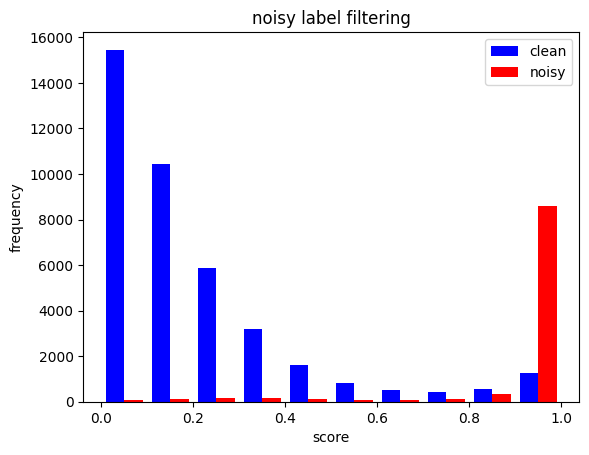

0.9691574631369061


In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

score = result['loss']
# score = result['mean'] + 0.5*result['std']
# score = result['mean'] - 0.5*result['std']
# score = result['std']

blue_data = score[~result['is_noisy']]
red_data = score[result['is_noisy']]
auroc = roc_auc_score(is_noisy, score)

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}", transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')
ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])

ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")
ax.legend()
plt.show()

## Loss magnitude based filtering (single forward pass)

In [3]:
# loss magnitude-based filtering
from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F



transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train


with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    result = {
        'loss': [],
        'is_noisy': [],
    }
    for batch in dataloader:
        data, target = batch["image"].cuda(), batch["target"].cuda()
        target_gt = batch["target_gt"].cuda()
        data = transform_normalize(data)
        output = trainer.model(data)
        loss = trainer.criterion(output, target)
        is_noisy = (target != target_gt)
        result['loss'].append(loss)
        result['is_noisy'].append(is_noisy)

    result['loss'] = torch.cat(result['loss'], dim=0).cpu()
    result['is_noisy'] = torch.cat(result['is_noisy'], dim=0).cpu()

pprint.pprint(result)

Files already downloaded and verified
{'is_noisy': tensor([ True, False, False,  ..., False,  True,  True]),
 'loss': tensor([9.9999e-01, 0.0000e+00, 2.3842e-06,  ..., 2.5922e-04, 1.0000e+00,
        9.9999e-01])}


In [4]:
result['loss']

tensor([9.9999e-01, 0.0000e+00, 2.3842e-06,  ..., 2.5922e-04, 1.0000e+00,
        9.9999e-01])

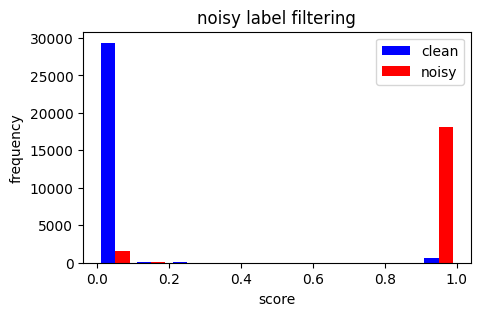

AUROC: 0.9733149005747264


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

score = result['loss']
# score = result['mean'] + 0.5*result['std']
# score = result['mean'] - 0.5*result['std']
# score = result['std']

blue_data = score[~result['is_noisy']]
red_data = score[result['is_noisy']]
auroc = roc_auc_score(is_noisy, score)

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}", transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')
ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])

ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")
ax.legend()
plt.show()

## perturbation-based filtering by estimating dirichlet distribution

In [38]:
# perturbation-based filtering
# for estimating dirichlet distribution entropy

from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F



transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train


with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    results = {
        'logit': [],
        'loss': [],
        'target': [],
        'target_gt': [],
    }
    for batch in dataloader:
        data, target = batch["image"].cuda(), batch["target"].cuda()
        target_gt = batch["target_gt"].cuda()
        result = {
            'logit': [],
            'loss': [],
        }
        for _ in range(100):
            # data_ = torch.normal(transform_normalize(data), 0.1)
            data_ = transform_tta(data)
            output = trainer.model(data_)
            loss = trainer.criterion(output, target)
            result['logit'].append(output)
            result['loss'].append(loss)
        result['logit'] = torch.stack(result['logit'], dim=-2)
        result['loss'] = torch.stack(result['loss'], dim=-1)
        results['logit'].append(result['logit'])
        results['loss'].append(result['loss'])
        results['target'].append(target)
        results['target_gt'].append(target_gt)

    results['logit'] = torch.cat(results['logit'], dim=0).cpu()
    results['loss'] = torch.cat(results['loss'], dim=0).cpu()
    results['target'] = torch.cat(results['target'], dim=0).cpu()
    results['target_gt'] = torch.cat(results['target_gt'], dim=0).cpu()


pprint.pprint(results)

Files already downloaded and verified
{'logit': tensor([[[ -2.1602,   2.0157,  -4.9380,  ...,  -2.5221,  -1.2355,  -5.9756],
         [  4.9457,   3.4917,  -7.9251,  ...,   1.5963,  -3.9554,   3.6843],
         [ -2.2870,   1.7951,  -4.7126,  ...,  -1.9573,  -1.6994,  -6.5016],
         ...,
         [ -4.1058,   6.6168,  -0.1880,  ...,  -3.4171,  -3.8254,  -3.2090],
         [ -2.2870,   1.7951,  -4.7126,  ...,  -1.9573,  -1.6994,  -6.5016],
         [ -2.2870,   1.7951,  -4.7126,  ...,  -1.9573,  -1.6994,  -6.5016]],

        [[  8.2736,   5.2546, -13.8468,  ...,  -4.9621,   2.5193,  20.0269],
         [ -2.5532,  -3.8122,   0.4225,  ...,   9.1137,   1.5777,  -0.5117],
         [  7.7221,   5.6024, -13.5597,  ...,  -5.6003,   2.1162,  20.0337],
         ...,
         [  3.3617,   0.3426, -14.4359,  ...,  -0.9384,   4.3554,  14.7326],
         [  7.7221,   5.6024, -13.5597,  ...,  -5.6003,   2.1162,  20.0337],
         [  7.7221,   5.6024, -13.5597,  ...,  -5.6003,   2.1162,  20.0337]

In [39]:
# save intermediate results in case of crash
torch.save(results, "results.pt")

### Dirichlet parameter estimation algorithms

In [41]:
# MLE algorithm implemented in https://github.com/ericsuh/dirichlet
import numpy
import dirichlet

alpha = numpy.array([100, 299, 1e-2, 14, 201, 449, 129])
data = numpy.random.dirichlet(alpha, 10)

alpha_hat = dirichlet.mle(data)
alpha_hat

array([1.67163339e+02, 4.85508291e+02, 7.06412649e-03, 2.39601016e+01,
       3.29187602e+02, 7.25486795e+02, 2.14350016e+02])

In [42]:
dirichlet.mle(data, method='fixedpoint')

array([0.08627898, 0.09559537, 0.08429229, 0.07852801, 0.08049584,
       0.06059681, 0.07419641, 0.05203358, 0.1400893 , 0.35771788])

In [25]:
# MLE algorithm implemented using PyTorch L-BFGS
import torch

def fit_dirichlet_pytorch(data):
    k = data.shape[-1]
    param = torch.rand((k,), dtype=data.dtype, requires_grad=True)
    dirichlet = torch.distributions.dirichlet.Dirichlet(param)

    optimizer = torch.optim.LBFGS([param], lr=0.001, max_iter=20, line_search_fn='strong_wolfe')

    def closure():
        optimizer.zero_grad()
        loss = - dirichlet.log_prob(data).sum()
        loss.backward()
        return loss

    for _ in range(10):
        optimizer.step(closure)

    return param.detach()


alpha = torch.tensor([10.0, 1.0, 5.0, 1.0])
data = torch.distributions.dirichlet.Dirichlet(alpha).sample((100,))

alpha_hat = fit_dirichlet_pytorch(data)

In [34]:
fit_dirichlet_pytorch(results['logit'].to(torch.float64).softmax(-1).unbind()[9])

tensor([1.6271, 0.0838, 0.0845, 0.1509, 0.0740, 0.1164, 0.0862, 0.0763, 0.0814,
        0.1411], dtype=torch.float64)

In [130]:
is_noisy[:10]

array([ True, False, False, False,  True, False,  True,  True, False,
        True])

In [14]:
# results['logit'].to(torch.float64).softmax(-1).shape
results['logit'].to(torch.float64).softmax(-1).unbind()[0].shape

torch.Size([10, 10])

In [9]:
results['logit'].to(torch.float64).softmax(-1).shape

torch.Size([50000, 10, 10])

In [35]:
from tqdm.contrib.concurrent import process_map  # or thread_map

items = results['logit'].to(torch.float64).softmax(-1).unbind(0)
processed_items = process_map(fit_dirichlet_pytorch, items, max_workers=10)

/tmp/ipykernel_55990/3929253804.py:4: TqdmWarning: Iterable length 50000 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  processed_items = process_map(fit_dirichlet_pytorch, items, max_workers=10)


  0%|          | 0/50000 [00:00<?, ?it/s]

RuntimeError: Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork

In [39]:
import multiprocess as mp
# from torch.multiprocessing import Pool


items = results['logit'].to(torch.float64).softmax(-1).unbind(0)

ctx = mp.get_context('spawn')
with ctx.Pool(10) as pool:
    processed_items = pool.map(fit_dirichlet_pytorch, items)

In [36]:
import torch.multiprocessing as mp
# from torch.multiprocessing import Pool


items = results['logit'].to(torch.float64).softmax(-1).unbind(0)

ctx = mp.get_context('spawn')
with ctx.Pool(10) as pool:
    processed_items = pool.map(fit_dirichlet_pytorch, items)

Process SpawnPoolWorker-15:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'fit_dirichlet_pytorch' on <module '__main__' (built-in)>
Process SpawnPoolWorker-16:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/

KeyboardInterrupt: 

In [57]:
# MLE algorithm implemented using SciPy L-BFGS

import numpy as np
from scipy.special import psi, gammaln
from scipy.optimize import minimize
import scipy
import scipy.stats

def dirichlet_log_likelihood(alpha, data):
    n, k = data.shape
    log_likelihood = n * (gammaln(np.sum(alpha)) - np.sum(gammaln(alpha))) + np.sum((alpha - 1) * np.sum(np.log(data), axis=0))
    return -log_likelihood

def dirichlet_gradient(alpha, data):
    n, k = data.shape
    gradient = n * (psi(np.sum(alpha)) - psi(alpha)) + np.sum(np.log(data), axis=0)
    return -gradient

def fit_dirichlet(data, initial_alpha=None):
    data = np.array(data)
    if initial_alpha is None:
        initial_alpha = np.ones(data.shape[1])

    result = minimize(
        dirichlet_log_likelihood, initial_alpha, args=(data),
        jac=dirichlet_gradient, method='L-BFGS-B', bounds=[(1e-6, None) for _ in initial_alpha]
    )

    if result.success:
        return result.x
    else:
        raise ValueError("Failed to fit Dirichlet distribution: " + result.message)


# Example data
alpha = [10.0, 1.0, 5.0, 1.0]
data = scipy.stats.dirichlet(alpha).rvs(1000)
# data = results['logit'].to(torch.double).softmax(-1).numpy()[3]

# Fit the Dirichlet distribution
alpha_hat = fit_dirichlet(data)
print("Estimated alpha parameters:", alpha_hat)


Estimated alpha parameters: [9.68757704 0.97952433 4.97661203 0.98901869]


In [60]:
# import multiprocess as mp
from torch.multiprocessing import Pool

items = results['logit'].to(torch.float64).softmax(-1).unbind(0)
items = [np.array(x) for x in items]

with Pool(1000) as pool:
    processed_items = pool.map(fit_dirichlet, items)

In [72]:
processed_items = np.array(processed_items)
processed_items.shape

(50000, 10)

In [11]:
np.array(processed_items)[0]

array([0.07392509, 0.09778622, 0.07857815, 0.09688988, 0.06868253,
       0.21338689, 0.11196087, 0.07313143, 0.07801399, 0.06190548])

In [49]:
alpha2 = []
for vec in results['logit'].to(torch.double).softmax(-1).numpy():
    alpha2.append(fit_dirichlet(vec))

alpha2 = np.array(alpha2)

In [51]:
alpha2.shape

(50000, 10)

In [13]:
# calculate entropy of Dirichlet distribution

import numpy as np
from scipy.special import gammaln, psi

def dirichlet_entropy(alpha):
    alpha0 = np.sum(alpha)
    k = len(alpha)
    
    log_beta = np.sum(gammaln(alpha)) - gammaln(alpha0)
    entropy = log_beta + (alpha0 - k) * psi(alpha0) - np.sum((alpha - 1) * psi(alpha))
    
    return entropy

def batched_dirichlet_entropy(alpha):
    b, k = alpha.shape
    alpha0 = np.sum(alpha, axis=1)
    
    log_beta = np.sum(gammaln(alpha), axis=1) - gammaln(alpha0)
    entropy = log_beta + (alpha0 - k) * psi(alpha0) - np.sum((alpha - 1) * psi(alpha), axis=1)
    
    return entropy

# Example usage
alpha = np.array([3, 5, 2])
entropy = dirichlet_entropy(alpha)
print("Entropy of the Dirichlet distribution:", entropy)

# Example usage
alpha = np.array([3, 5, 2])[np.newaxis, :].repeat(10, axis=0)
entropy = batched_dirichlet_entropy(alpha)
print("Entropy of the Dirichlet distribution:", entropy)


Entropy of the Dirichlet distribution: -1.4611820247291334
Entropy of the Dirichlet distribution: [-1.46118202 -1.46118202 -1.46118202 -1.46118202 -1.46118202 -1.46118202
 -1.46118202 -1.46118202 -1.46118202 -1.46118202]


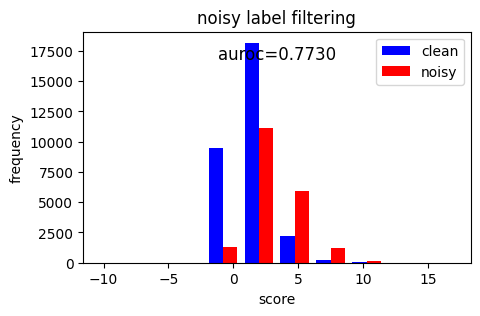

In [109]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

score = entropy
is_noisy = (results['target'] != results['target_gt']).numpy()

auroc = roc_auc_score(is_noisy, score)
blue_data = score[~is_noisy]
red_data = score[is_noisy]

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}",transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')
ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])

ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")
ax.legend()
plt.show()

In [48]:
print(entropy.min(), entropy.max())

-10494451000000.0 -75.583466


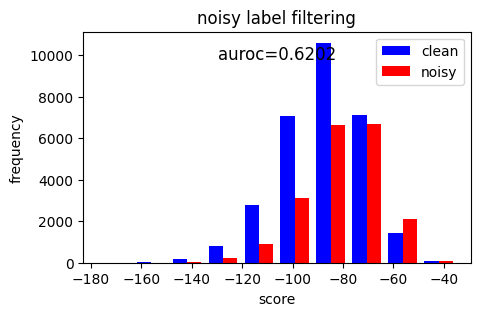

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

entropy = batched_dirichlet_entropy(processed_items)

score = entropy
is_noisy = (results['target'] != results['target_gt']).numpy()

auroc = roc_auc_score(is_noisy, score)

blue_data = score[~is_noisy]
red_data = score[is_noisy]

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}",transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')
ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])

ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")
ax.legend()
plt.show()


## fixed perturbation-based filtering

현재 메소드는 perturbed prediction 간의 disagreement 를 측정하고 있는데, 이게 아니라 unperturbed prediction vs. perturbed prediction 간의 disagreement 를 측정하는게 더 좋을 것 같다.

In [77]:
# perturbation-based filtering
# for estimating dirichlet distribution entropy

from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torch.nn.functional as F



transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train


with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    results = {
        'kldiv': [],
        'target': [],
        'target_gt': [],
    }
    for batch in dataloader:
        data, target = batch["image"].cuda(), batch["target"].cuda()
        target_gt = batch["target_gt"].cuda()
        pred = trainer.model(transform_normalize(data)).softmax(dim=-1)

        ensemble = []
        for _ in range(10):
            # data_ = torch.normal(transform_normalize(data), 0.1)
            data_ = transform_tta(data)
            output = trainer.model(data_)
            ensemble.append(output.softmax(dim=-1))
        ensemble = torch.stack(ensemble, dim=0).mean(0)

        results['kldiv'].append(F.kl_div(pred, ensemble, reduction='none').sum(1))
        results['target'].append(target)
        results['target_gt'].append(target_gt)

    results['kldiv'] = torch.cat(results['kldiv'], dim=0).cpu()
    results['target'] = torch.cat(results['target'], dim=0).cpu()
    results['target_gt'] = torch.cat(results['target_gt'], dim=0).cpu()


pprint.pprint(results)

Files already downloaded and verified
{'kldiv': tensor([[-1.8653e-02, -4.5042e-02, -3.6516e-01,  ..., -1.2719e-03,
         -1.3116e-01, -2.2392e-01],
        [-5.9909e-02, -1.1275e-02, -9.5148e-02,  ..., -1.5345e-01,
         -1.0603e-01, -9.9113e-01],
        [-2.6669e-01, -1.5503e-01, -1.6335e-01,  ..., -1.2745e-02,
         -3.2046e-01, -8.5889e-01],
        ...,
        [-4.4421e-02, -3.0599e-03, -2.4050e-01,  ..., -1.3455e-03,
         -1.1923e-01, -9.8478e-01],
        [-5.9184e-03, -4.0437e-01, -4.1164e-04,  ..., -1.9883e-01,
         -7.3964e-01, -4.4795e-02],
        [-2.4039e-01, -2.2092e-01, -2.2241e-02,  ..., -2.2393e-01,
         -2.6908e-03, -3.3409e-03]]),
 'target': tensor([5, 9, 9,  ..., 9, 8, 3]),
 'target_gt': tensor([6, 9, 9,  ..., 9, 1, 1])}


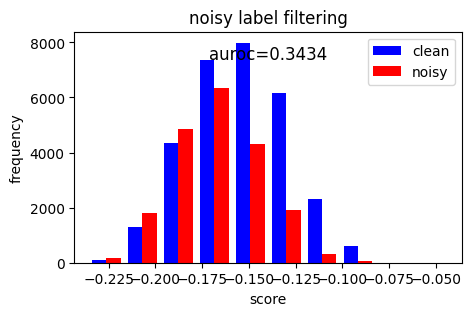

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


score = results['kldiv']
is_noisy = (results['target'] != results['target_gt']).numpy()

auroc = roc_auc_score(is_noisy, score)

blue_data = score[~is_noisy]
red_data = score[is_noisy]

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}",transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')

ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])

# add title and axis labels
ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")


# add legend
ax.legend()

# display the histogram
plt.show()


## AUROC per training epoch

In [ ]:
def load_checkpoint(name="model_199.pth"):
    checkpoint = wandb.restore(name, run_path=f"siit-iitp/noisy-label/{WANDB_RUN_ID}", replace=True)
    model.load_state_dict(torch.load(checkpoint.name, map_location="cuda"))

In [ ]:
# perturbation-based filtering

from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F



transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train



with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    results = []

    for ep in range(9, 200, 10):
        load_checkpoint(f"model_{ep}.pth")

        result = {
            'loss': [],
            'std': [],
            'mean': [],
            'is_noisy': [],
        }
        for batch in dataloader:
            data, target = batch["image"].cuda(), batch["target"].cuda()
            target_gt = batch["target_gt"].cuda()

            data_ = transform_normalize(data)
            output = trainer.model(data_)
            loss = trainer.criterion(output, target)
            result['loss'].append(loss)

            losses = []
            for _ in range(10):
                # data_ = torch.normal(transform_normalize(data), 0.1)
                data_ = transform_tta(data)
                output = trainer.model(data_)
                loss = trainer.criterion(output, target)
                losses.append(loss)
            std, mean = torch.std_mean(torch.stack(losses, dim=-1), dim=-1)
            is_noisy = (target != target_gt)
            result['std'].append(std)
            result['mean'].append(mean)
            result['is_noisy'].append(is_noisy)

        result['std'] = torch.cat(result['std'], dim=0).cpu()
        result['mean'] = torch.cat(result['mean'], dim=0).cpu()
        result['is_noisy'] = torch.cat(result['is_noisy'], dim=0).cpu()
        results.append(result)

pprint.pprint(result)

In [ ]:
# save intermediate results in case of crash
torch.save(results, "./test-time.pth")

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score

temp = []
for result in results:
    temp.append({
        'loss': roc_auc_score(result['is_noisy'], result['loss']),
        'loss mean': roc_auc_score(result['is_noisy'], result['mean']),
        'mean + 0.5*std': roc_auc_score(result['is_noisy'], result['mean'] + 0.5*result['std']),
        'mean - 0.5*std': roc_auc_score(result['is_noisy'], result['mean'] - 0.5*result['std']),
        'std': roc_auc_score(result['is_noisy'], result['std']),
    })

temp = pd.DataFrame(temp)
temp['epoch'] = list(range(9,200,10))
temp = temp.set_index('epoch')
temp

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = temp

fig, ax = plt.subplots()
df.plot(ax=ax)

ax.set_xlabel('epoch')
ax.set_ylabel('filtering performance (AUROC)')
plt.show()


## Latent-space perturbation

In [3]:
from models import MCDropout, GaussianMCDropout

# dropout = MCDropout
dropout = GaussianMCDropout

trainer.model.register_module("dropout", dropout())
def forward(self, x):
    x = self.get_feature(x)
    x = self.dropout(x)
    x = self.fc(x)
    return x
setattr(trainer.model, 'forward', forward.__get__(trainer.model, trainer.model.__class__))

model = torch.jit.script(model)

In [4]:
# loss magnitude-based filtering
from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F


transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train


with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    result = {
        'output': [],
        'target': [],
        'target_gt': [],
    }
    for batch in dataloader:
        data, target = batch["image"].cuda(), batch["target"].cuda()
        target_gt = batch["target_gt"].cuda()
        
        outputs = []
        for _ in range(100):
            data_ = transform_normalize(data)
            output = trainer.model(data_)
            outputs.append(output)
        output = torch.stack(outputs, dim=1) # (B, n, c)

        result['output'].append(output)
        result['target'].append(target)
        result['target_gt'].append(target_gt)

    result = {k: torch.cat(v, dim=0).cpu() for k, v in result.items()}

pprint.pprint(result)

Files already downloaded and verified
Files already downloaded and verified
{'output': tensor([[[-3.3565, -0.5135, -0.8019,  ..., -1.4148, -0.4375, -1.4205],
         [-3.2466, -0.4379, -0.6319,  ..., -1.1423, -0.1886, -1.3958],
         [-3.0438,  0.0174, -0.7435,  ..., -1.2091, -0.2708, -1.2289],
         ...,
         [-3.3253, -0.1040, -0.4741,  ..., -1.1770, -0.1531, -1.5789],
         [-3.1940, -0.4768, -0.6296,  ..., -1.2420, -0.2948, -1.3297],
         [-3.5218, -0.1291, -0.5952,  ..., -1.2094, -0.2669, -1.5303]],

        [[-2.0267,  0.5579, -1.9339,  ..., -0.1917, -0.4507,  9.5750],
         [-2.1929,  0.5412, -2.3352,  ..., -0.2904,  0.0251, 10.1249],
         [-1.8550,  0.5734, -2.0669,  ...,  0.1325,  0.0799,  8.9664],
         ...,
         [-2.2085,  0.5947, -2.0074,  ...,  0.1657, -1.1593,  9.7129],
         [-2.7620,  1.6423, -2.1072,  ..., -0.6796, -1.3304, 11.3303],
         [-2.6888,  0.7001, -2.5288,  ..., -0.1243, -0.3323, 11.5579]],

        [[-0.9117, -0.4746, -

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# score = result['mean']
# score = result['mean'] + 0.5*result['std']
# score = result['mean'] - 0.5*result['std']
score = result['std']

is_noisy = result['is_noisy']

auroc = roc_auc_score(is_noisy, score)

blue_data = score[~is_noisy]
red_data = score[is_noisy]

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}",transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')
ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])

ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")
ax.legend()
plt.show()


In [5]:
import pandas as pd

df = pd.DataFrame({
    'output': torch.unbind(result['output']), # (50000, 10, 10)
    'is_noisy': (result['target'] != result['target_gt']).tolist(), # (50000, 11, 10)
    'target': result['target'].tolist(), # (50000,)
    'target_gt': result['target_gt'].tolist(), # (50000,)
    })

df_clean = df[df['is_noisy']==False]
df_noisy = df[df['is_noisy']==True]

df

,output,is_noisy,target,target_gt
0,"[[tensor(-3.3565), tensor(-0.5135), tensor(-0....",True,5,6
1,"[[tensor(-2.0267), tensor(0.5579), tensor(-1.9...",False,9,9
2,"[[tensor(-0.9117), tensor(-0.4746), tensor(-2....",False,9,9
3,"[[tensor(-1.3387), tensor(-1.5848), tensor(-0....",False,4,4
4,"[[tensor(-1.3043), tensor(8.4071), tensor(-1.7...",True,9,1
...,...,...,...,...
49995,"[[tensor(7.6092), tensor(-0.2459), tensor(-0.2...",False,2,2
49996,"[[tensor(-1.5518), tensor(0.7809), tensor(0.58...",False,6,6
49997,"[[tensor(0.2465), tensor(0.9895), tensor(-1.15...",False,9,9
49998,"[[tensor(-2.2491), tensor(13.2623), tensor(-2....",True,8,1


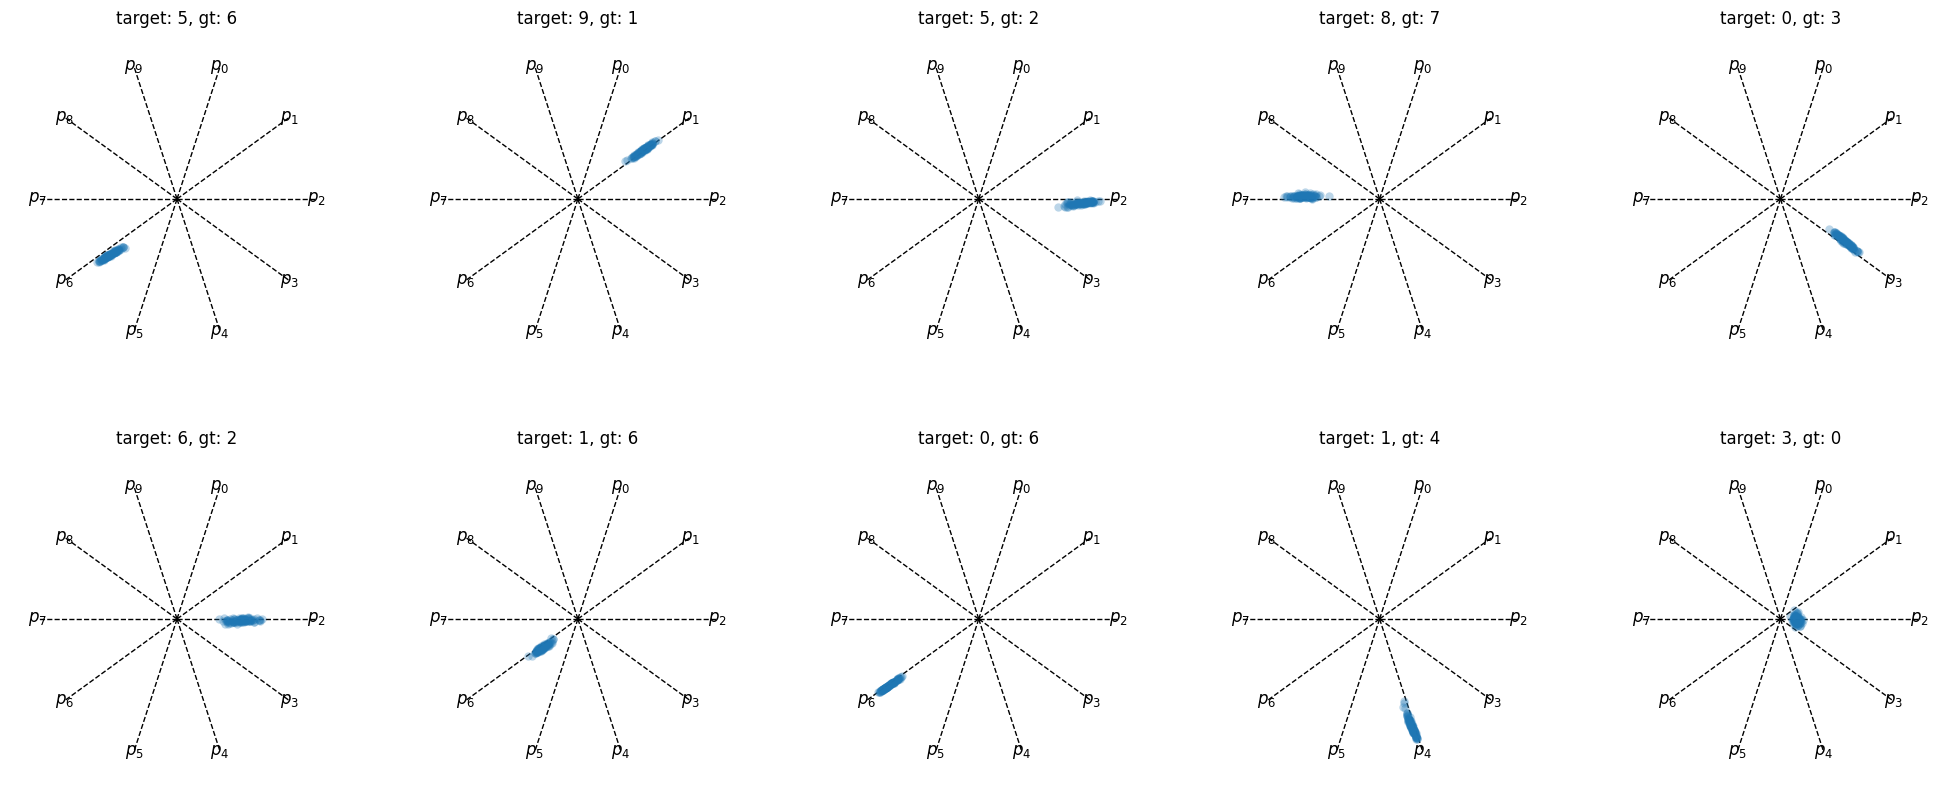

In [7]:
import numpy as np
import torch

def get_projection_matrix(k):
    theta = (2*np.pi/k) * (np.arange(k) + 0.5)
    return np.stack([np.sin(theta), np.cos(theta)], axis=0)

num_classes = 10
T = get_projection_matrix(num_classes)


import numpy.random as nprn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
from scipy.special import softmax


num_class = config["model"]["num_classes"] # CIFAR-10

fig = plt.figure(figsize=(25,10))
for idx in range(10):
    row = df_noisy.iloc[idx]
    # row = df_clean.iloc[idx]
    x = row['output'].div(3).softmax(-1).numpy()

    points = T @ x.T

    ax = fig.add_subplot(2,5,idx + 1)

    # Plot the octagon
    vertices = T @ np.eye(num_classes)
    vertices = np.hstack([vertices, vertices[:, 0:1]])
    for i, vertex in enumerate(vertices[:,:-1].T):
        ax.text(vertex[0], vertex[1], f"$p_{i}$", ha='center', va='center', fontsize=12)
        ax.plot([0, vertex[0]], [0, vertex[1]], 'k--', linewidth=1)

    # Plot the points
    ax.scatter(points[0], points[1], linewidth=0, alpha=0.3, zorder=10)

    # Set the axis limits
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.set_title(f"target: {row['target']}, gt: {row['target_gt']}")
    ax.set_axis_off()

# Show the plot
plt.show()

### use both MC dropout and input perturbation

In [ ]:
from models import MCDropout, GaussianMCDropout

dropout = MCDropout
# dropout = GaussianMCDropout

trainer.model.register_module("dropout", dropout())
def forward(self, x):
    x = self.get_feature(x)
    x = self.dropout(x)
    x = self.fc(x)
    return x
setattr(trainer.model, 'forward', forward.__get__(trainer.model, trainer.model.__class__))




# loss magnitude-based filtering
from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F


transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train


with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    result = {
        'std': [],
        'mean': [],
        'is_noisy': [],
    }
    for batch in dataloader:
        data, target = batch["image"].cuda(), batch["target"].cuda()
        target_gt = batch["target_gt"].cuda()
        losses = []
        for _ in range(10):
            # data_ = torch.normal(transform_normalize(data), 0.1)
            data_ = transform_tta(data)
            output = trainer.model(data_)
            loss = trainer.criterion(output, target)
            losses.append(loss)
        std, mean = torch.std_mean(torch.stack(losses, dim=-1), dim=-1)
        is_noisy = (target != target_gt)
        result['std'].append(std)
        result['mean'].append(mean)
        result['is_noisy'].append(is_noisy)

    result['std'] = torch.cat(result['std'], dim=0).cpu()
    result['mean'] = torch.cat(result['mean'], dim=0).cpu()
    result['is_noisy'] = torch.cat(result['is_noisy'], dim=0).cpu()

pprint.pprint(result)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# score = result['mean']
# score = result['mean'] + 0.5*result['std']
# score = result['mean'] - 0.5*result['std']
score = result['std']

is_noisy = result['is_noisy']

auroc = roc_auc_score(is_noisy, score)

blue_data = score[~is_noisy]
red_data = score[is_noisy]

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}",transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')
ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])

ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")
ax.legend()
plt.show()


## Vanilla NVRM

In [30]:
import argparse
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import numpy as np
import random
import wandb
import models
import yaml
from trainer import Trainer
import pprint
from torchvision import transforms
import datasets


np.random.seed(0)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

# Load YAML config
with open("./configs/clean_cifar/cifar10_ce.yaml", 'r') as file:
    config = yaml.safe_load(file)

model = models.get_model(**config["model"]).cuda()


trainer = Trainer(
                model=model,
                config=config['trainer'],
                )


WANDB_RUN_ID = "kp6g82fq" # CIFAR10-CE

def load_checkpoint(name="model_199.pth"):
    checkpoint = wandb.restore(name, run_path=f"hyounguk-shon/noisy-label/{WANDB_RUN_ID}", replace=True, root='./temp')
    trainer.model.load_state_dict(torch.load(checkpoint.name, map_location="cuda"))
    print(f"Loaded checkpoint: {checkpoint.name}")

load_checkpoint(name="model_199.pth")


print(trainer.criterion)

Loaded checkpoint: ./temp/model_199.pth
CrossEntropyLoss()


In [73]:
# perturbation-based filtering
# TODO: 다른 weight로도 두세번 더 돌려보기!

import torchvision
from torchvision import transforms
import torchvision.transforms.v2 as transforms_v2

from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F
import tqdm.auto as tqdm


import random
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)


auto_augment = transforms_v2.AutoAugment(AutoAugmentPolicy.CIFAR10)
random_crop = transforms.Compose([
    transforms_v2.RandomCrop(32, padding=4),
    transforms_v2.RandomHorizontalFlip(),
])
num_augment = 100

transform_train = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1)),
    # transforms.Lambda(lambda x: torch.stack([x] + [auto_augment(x) for _ in range(num_augment)], dim=0)), # (11, C, H, W)
    # transforms.Lambda(lambda x: torch.stack([x] + [random_crop(x) for _ in range(num_augment)], dim=0)), # (11, C, H, W)
    # transforms.Lambda(lambda x: torch.stack([auto_augment(x) for _ in range(num_augment)] + [random_crop(x) for _ in range(num_augment)], dim=0)), # (11, C, H, W)
    transforms.Lambda(lambda x: torch.stack([auto_augment(x) for _ in range(num_augment)], dim=0)), # (11, C, H, W)
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010), inplace=True),
    # transforms.Lambda(lambda x: torch.stack([x] + [torch.normal(mean=x, std=0.1) for _ in range(num_augment)], dim=0)), # (11, C, H, W)
])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train

dataloader = trainer.get_dataloader(train_dataset, train=False)
dataloader.num_workers = 8

load_checkpoint(f"model_199.pth")

with torch.no_grad():
    trainer.model.eval()
    result = {
        'output': [],
        'loss': [],
        'std': [],
        'mean': [],
        'target': [],
    }
    for batch in tqdm.tqdm(dataloader):
        data = batch["image"].cuda() # (B, 11, 3, 32, 32)
        target = batch["target"].cuda()[:, None].repeat(1, data.size(1)) # (B, 11)

        b = data.size(0)
        data = data
        with torch.cuda.amp.autocast():
            output = trainer.model(data.view(-1,3,32,32)) # (B*11, 10)
            loss = trainer.criterion(output, target.view(-1)).view(b, -1) # (B, 11)
        raw_loss, aug_loss = loss[:, 0], loss[:, 1:]
        std, mean = torch.std_mean(aug_loss, dim=-1)

        result['output'].append(output.view(b, -1, 10))
        result['loss'].append(raw_loss)
        result['std'].append(std)
        result['mean'].append(mean)
        result['target'].append(target[:, 0])

    result = {k: torch.cat(v, dim=0).cpu() for k, v in result.items()}

# pprint.pprint(result)

Files already downloaded and verified
Loaded checkpoint: ./temp/model_199.pth


  0%|          | 0/391 [00:00<?, ?it/s]

In [74]:
import pandas as pd

df = pd.DataFrame({
    # 'pointpred': torch.unbind(result['output'][:,:num_augment,:]), # (50000, 10)
    'output': torch.unbind(result['output']), # (50000, 10, 10)
    # 'is_noisy': (result['target'] != result['target_gt']).tolist(), # (50000, 11, 10)
    'target': result['target'].tolist(), # (50000,)
    # 'target_gt': result['target_gt'].tolist(), # (50000,)
    })

df

,output,target
0,"[[tensor(-3.3535, dtype=torch.float16), tensor...",6
1,"[[tensor(-1.8828, dtype=torch.float16), tensor...",9
2,"[[tensor(1.7158, dtype=torch.float16), tensor(...",9
3,"[[tensor(-1.8975, dtype=torch.float16), tensor...",4
4,"[[tensor(-0.0257, dtype=torch.float16), tensor...",1
...,...,...
49995,"[[tensor(7.0430, dtype=torch.float16), tensor(...",2
49996,"[[tensor(-0.4856, dtype=torch.float16), tensor...",6
49997,"[[tensor(0.9497, dtype=torch.float16), tensor(...",9
49998,"[[tensor(-2., dtype=torch.float16), tensor(15....",1


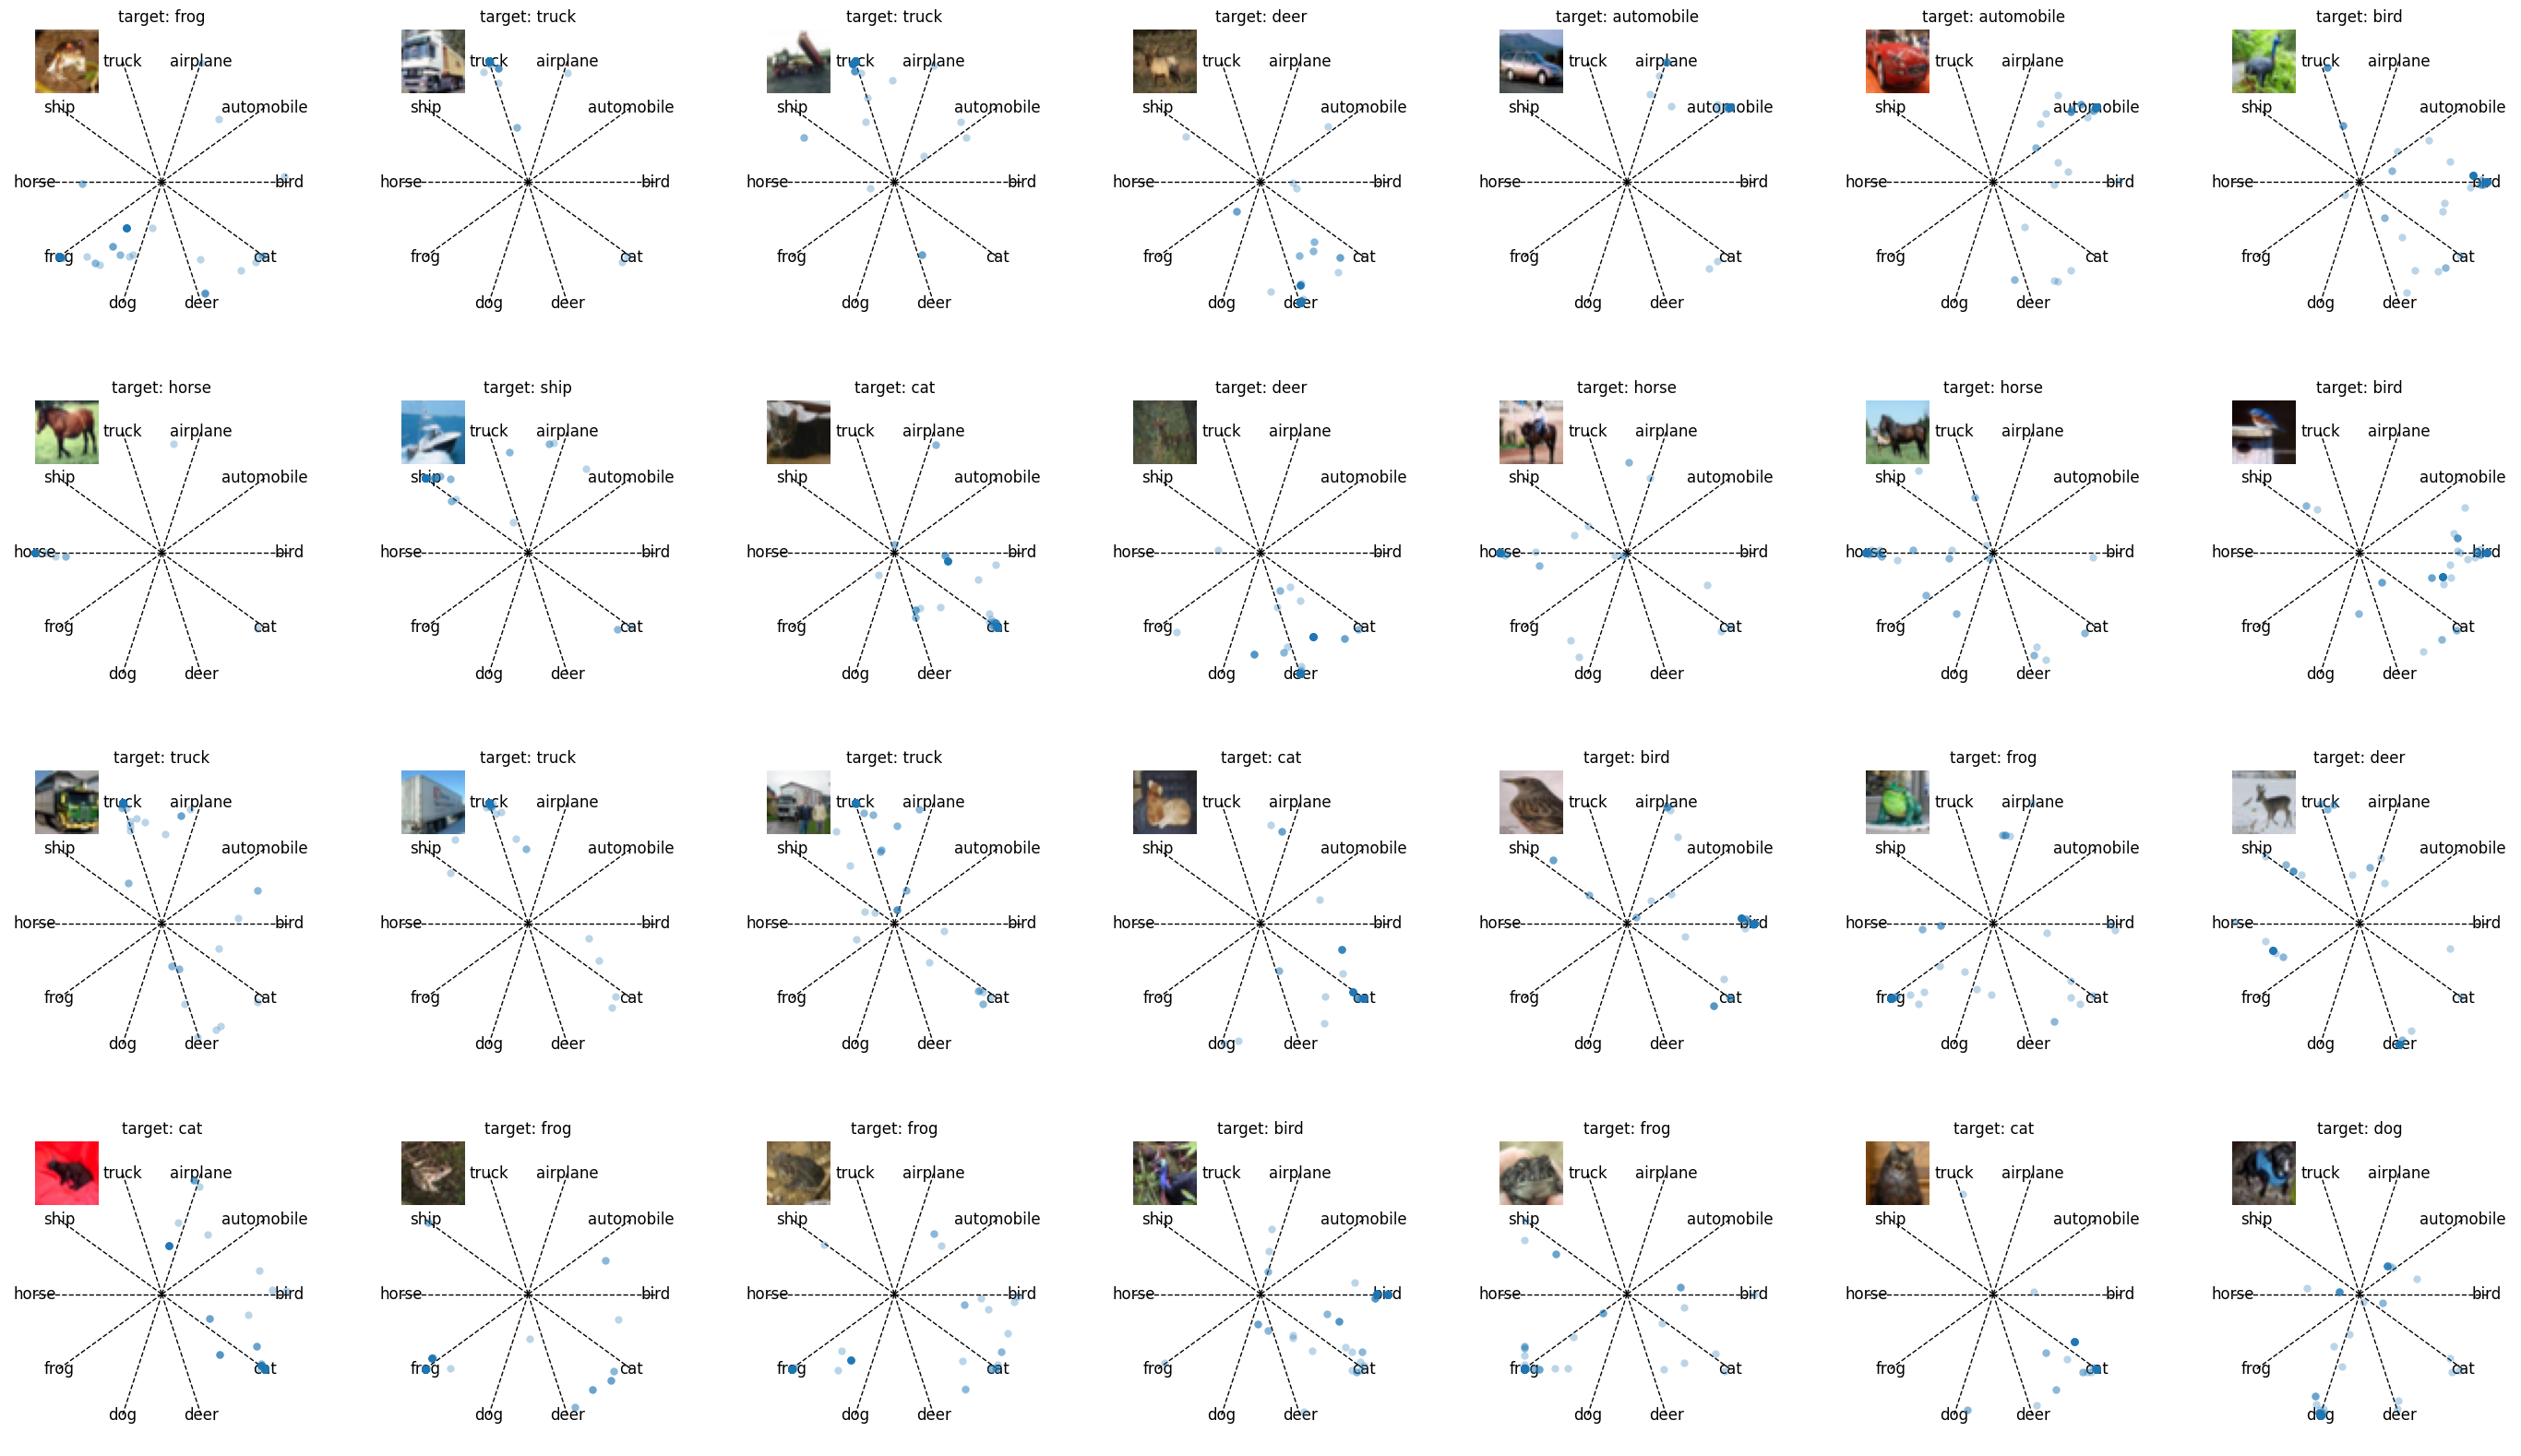

In [75]:
import numpy as np
import torch

def get_projection_matrix(k):
    theta = (2*np.pi/k) * (np.arange(k) + 0.5)
    return np.stack([np.sin(theta), np.cos(theta)], axis=0)

num_classes = 10
T = get_projection_matrix(num_classes)

# df_clean = df[df['is_noisy']==False]
# df_noisy = df[df['is_noisy']==True]
df_clean = df

import numpy.random as nprn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
from scipy.special import softmax


num_class = config["model"]["num_classes"] # CIFAR-10
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train_dataset.transform = lambda x: np.array(x)



fig = plt.figure(figsize=(35,20))
for idx in range(28):
    # row = df_noisy.iloc[idx]
    row = df_clean.iloc[idx]
    x = row['output'].float().div(1).softmax(-1).numpy()
    # pointpred = row['pointpred'][None, :].softmax(-1).numpy()
    # pointpred = row['pointpred'].float().div(1).softmax(-1).numpy()

    points = T @ x.T
    # pointpred = T @ pointpred.T

    ax = fig.add_subplot(4,7,idx + 1)

    # Plot the octagon
    vertices = T @ np.eye(num_classes)
    vertices = np.hstack([vertices, vertices[:, 0:1]])
    for i, vertex in enumerate(vertices[:,:-1].T):
        ax.text(vertex[0], vertex[1], cifar10_classes[i], ha='center', va='center', fontsize=12)
        ax.plot([0, vertex[0]], [0, vertex[1]], 'k--', linewidth=1)

    # Plot the points
    ax.scatter(points[0], points[1], linewidth=0, alpha=0.3, zorder=10)
    # ax.scatter([pointpred[0]], [pointpred[1]], color='red', alpha = 0.3, s=50, linewidth=0, zorder=12)
    image = train_dataset[idx]['image']
    ax.imshow(image, extent=[-1, -0.5, 0.7, 1.2])

    # # plot image
    # plt.figimage()

    # Set the axis limits
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.set_title(f"target: {cifar10_classes[row['target']]}")
    ax.set_axis_off()

# Show the plot
plt.show()